<a href="https://colab.research.google.com/github/andrewburner/msds422-titanic/blob/master/MSDS422_assign3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install scikit-plot

In [152]:
import numpy as np
import pandas as pd
import math
from math import exp

import statsmodels.formula.api as sm
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import scikitplot as skplt
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)

In [63]:
%matplotlib inline

In [64]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
train_path = '/content/drive/My Drive/MSDS 422/Assignment 3/train.csv'
test_path = '/content/drive/My Drive/MSDS 422/Assignment 3/test.csv'
training_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [67]:
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
training_df.shape

(891, 12)

In [69]:
test_df.shape

(418, 11)

In [70]:
training_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [71]:
training_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [72]:
training_df = training_df.drop(['PassengerId','Name','Ticket'],1)

In [73]:
training_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [74]:
print(549+342)
print(549/(549+342))

891
0.6161616161616161


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae8bff45f8>,
      dtype=object)

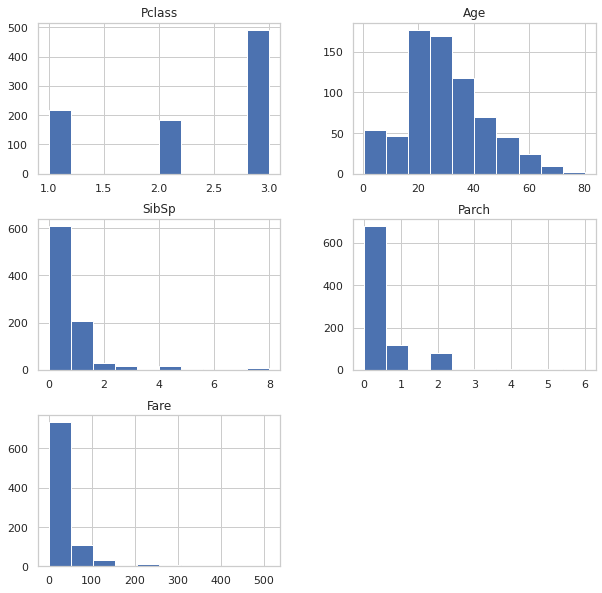

In [75]:
training_df.drop('Survived',1).hist(figsize=(10,10))

In [76]:
training_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [77]:
training_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [78]:
training_df['Cabin'].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
F2             3
C22 C26        3
              ..
D11            1
D28            1
C7             1
D45            1
E49            1
Name: Cabin, Length: 147, dtype: int64

In [79]:
training_df['Sex']=np.where(training_df['Sex']=='male',1,0)

In [80]:
test_df['Sex']=np.where(test_df['Sex']=='male',1,0)

In [81]:
training_df['Sex'].head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

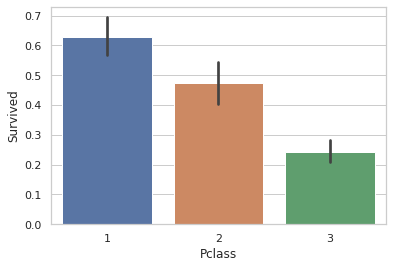

In [82]:
sns.barplot(x="Pclass", y="Survived", data=training_df)

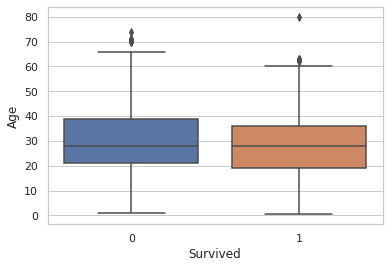

In [83]:
sns.boxplot(y="Age", x="Survived", data=training_df)

In [84]:
training_df1=training_df.groupby(["Pclass","SibSp"])
training_df1_median=training_df1.median()
training_df1_median

Survived  Sex   Age  Parch      Fare
Pclass SibSp                                      
1      0           1.0  1.0  37.0    0.0   39.6000
       1           1.0  0.0  38.0    0.0   79.2000
       2           1.0  0.0  44.0    0.0  133.6500
       3           1.0  0.0  23.0    2.0  263.0000
2      0           0.0  1.0  30.0    0.0   13.0000
       1           1.0  0.0  29.0    1.0   26.0000
       2           0.5  1.0  23.5    1.0   39.0000
       3           1.0  0.0  30.0    0.0   21.0000
3      0           0.0  1.0  26.0    0.0    7.8958
       1           0.0  1.0  25.0    0.0   15.5500
       2           0.0  1.0  19.5    0.0   19.2583
       3           0.0  0.0   6.0    1.0   25.4667
       4           0.0  1.0   6.5    1.5   31.2750
       5           0.0  1.0  11.0    2.0   46.9000
       8           0.0  1.0   NaN    2.0   69.5500

In [85]:
test_df1=test_df.groupby(["Pclass","SibSp"])
test_df1_median=test_df1.median()
test_df1_median

PassengerId  Sex   Age  Parch       Fare
Pclass SibSp                                          
1      0           1088.0  1.0  39.0    0.0   42.50000
       1           1109.5  0.5  46.0    0.0   82.06250
       2            969.0  0.0  55.0    0.0   51.47920
       3            945.0  0.0  28.0    2.0  263.00000
2      0           1117.5  1.0  27.0    0.0   13.00000
       1           1139.0  1.0  29.0    0.0   26.00000
       2           1077.5  0.5  21.0    0.5   31.50000
3      0           1095.5  1.0  24.0    0.0    7.82920
       1           1084.0  0.0  20.0    1.0   15.24580
       2           1059.0  1.0  19.5    0.0   21.67920
       3           1281.0  1.0  29.0    1.0   21.07500
       4           1076.0  1.0  11.5    2.0   30.25625
       5           1032.0  0.0  10.0    2.0   46.90000
       8           1166.0  0.5  14.5    2.0   69.55000

In [86]:
def impute_age(dataset,dataset_med):
    for x in range(len(dataset)):
        if dataset["Pclass"][x]==1:
            if dataset["SibSp"][x]==0:
                return dataset_med.loc[1,0]["Age"]
            elif dataset["SibSp"][x]==1:
                return dataset_med.loc[1,1]["Age"]
            elif dataset["SibSp"][x]==2:
                return dataset_med.loc[1,2]["Age"]
            elif dataset["SibSp"][x]==3:
                return dataset_med.loc[1,3]["Age"]
        elif dataset["Pclass"][x]==2:
            if dataset["SibSp"][x]==0:
                return dataset_med.loc[2,0]["Age"]
            elif dataset["SibSp"][x]==1:
                return dataset_med.loc[2,1]["Age"]
            elif dataset["SibSp"][x]==2:
                return dataset_med.loc[2,2]["Age"]
            elif dataset["SibSp"][x]==3:
                return dataset_med.loc[2,3]["Age"]
        elif dataset["Pclass"][x]==3:
            if dataset["SibSp"][x]==0:
                return dataset_med.loc[3,0]["Age"]
            elif dataset["SibSp"][x]==1:
                return dataset_med.loc[3,1]["Age"]
            elif dataset["SibSp"][x]==2:
                return dataset_med.loc[3,2]["Age"]
            elif dataset["SibSp"][x]==3:
                return dataset_med.loc[3,3]["Age"]
            elif dataset["SibSp"][x]==4:
                return dataset_med.loc[3,4]["Age"]
            elif dataset["SibSp"][x]==5:
                return dataset_med.loc[3,5]["Age"]
            elif dataset["SibSp"][x]==8:
                return dataset_med.loc[3]["Age"].median()

In [87]:
training_df["Age"]=training_df["Age"].fillna(impute_age(training_df,training_df1_median))
test_df["Age"]=test_df["Age"].fillna(impute_age(test_df,test_df1_median))

In [88]:
print(training_df.isnull().sum()), print(test_df.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


(None, None)

In [89]:
training_df["Cabin"]=training_df["Cabin"].fillna("U")
test_df["Cabin"]=test_df["Cabin"].fillna("U")
training_df["Cabin"]=training_df["Cabin"].map(lambda x: x[0])
test_df["Cabin"]=test_df["Cabin"].map(lambda x: x[0])

In [90]:
training_df["Cabin"].head()

0    U
1    C
2    U
3    C
4    U
Name: Cabin, dtype: object

In [91]:
training_df['Cabin'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [92]:
training_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,U,S
1,1,1,0,38.0,1,0,71.2833,C,C
2,1,3,0,26.0,0,0,7.9250,U,S
3,1,1,0,35.0,1,0,53.1000,C,S
4,0,3,1,35.0,0,0,8.0500,U,S


In [93]:
training_df.shape

(891, 9)

In [94]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [95]:
def cabin_assignment(dataset):
    dataset["Cabin A"]=np.where(dataset["Cabin"]=="A",1,0)
    dataset["Cabin B"]=np.where(dataset["Cabin"]=="B",1,0)
    dataset["Cabin C"]=np.where(dataset["Cabin"]=="C",1,0)
    dataset["Cabin D"]=np.where(dataset["Cabin"]=="D",1,0)
    dataset["Cabin E"]=np.where(dataset["Cabin"]=="E",1,0)
    dataset["Cabin F"]=np.where(dataset["Cabin"]=="F",1,0)
    dataset["Cabin G"]=np.where(dataset["Cabin"]=="G",1,0)
    dataset["Cabin T"]=np.where(dataset["Cabin"]=="T",1,0)

In [96]:
cabin_assignment(training_df)
cabin_assignment(test_df)

In [97]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    object 
 8   Embarked  889 non-null    object 
 9   Cabin A   891 non-null    int64  
 10  Cabin B   891 non-null    int64  
 11  Cabin C   891 non-null    int64  
 12  Cabin D   891 non-null    int64  
 13  Cabin E   891 non-null    int64  
 14  Cabin F   891 non-null    int64  
 15  Cabin G   891 non-null    int64  
 16  Cabin T   891 non-null    int64  
dtypes: float64(2), int64(13), object(2)
memory usage: 118.5+ KB


In [98]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  Cabin A      418 non-null    int64  
 12  Cabin B      418 non-null    int64  
 13  Cabin C      418 non-null    int64  
 14  Cabin D      418 non-null    int64  
 15  Cabin E      418 non-null    int64  
 16  Cabin F      418 non-null    int64  
 17  Cabin G      418 non-null    int64  
 18  Cabin T      418 non-null    int64  
dtypes: float

In [99]:
training_df["Embarked"]=training_df["Embarked"].fillna("S")

In [100]:
training_df["Embarked"].isnull().sum()

0

In [101]:
def embark_assignment(dataset):
    dataset["Embarked S"]=np.where(dataset["Embarked"]=="S",1,0)
    dataset["Embarked C"]=np.where(dataset["Embarked"]=="C",1,0)

In [102]:
embark_assignment(training_df)
embark_assignment(test_df)

In [103]:
test_df["Fare"]=test_df["Fare"].fillna(np.mean(test_df["Fare"]))

In [104]:
test_df["Fare"].isnull().sum()

0

In [105]:
training_df["FamilySize"] = training_df["SibSp"] + training_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

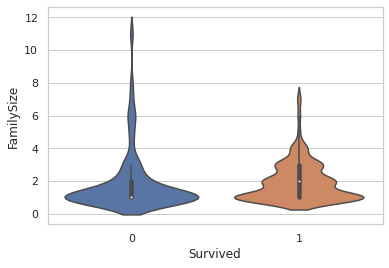

In [106]:
sns.violinplot(y="FamilySize", x="Survived", data=training_df)

In [107]:
training_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin A,Cabin B,Cabin C,Cabin D,Cabin E,Cabin F,Cabin G,Cabin T,Embarked S,Embarked C,FamilySize
0,0,3,1,22.0,1,0,7.2500,U,S,0,0,0,0,0,0,0,0,1,0,2
1,1,1,0,38.0,1,0,71.2833,C,C,0,0,1,0,0,0,0,0,0,1,2
2,1,3,0,26.0,0,0,7.9250,U,S,0,0,0,0,0,0,0,0,1,0,1
3,1,1,0,35.0,1,0,53.1000,C,S,0,0,1,0,0,0,0,0,1,0,2
4,0,3,1,35.0,0,0,8.0500,U,S,0,0,0,0,0,0,0,0,1,0,1


In [108]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Cabin       891 non-null    object 
 8   Embarked    891 non-null    object 
 9   Cabin A     891 non-null    int64  
 10  Cabin B     891 non-null    int64  
 11  Cabin C     891 non-null    int64  
 12  Cabin D     891 non-null    int64  
 13  Cabin E     891 non-null    int64  
 14  Cabin F     891 non-null    int64  
 15  Cabin G     891 non-null    int64  
 16  Cabin T     891 non-null    int64  
 17  Embarked S  891 non-null    int64  
 18  Embarked C  891 non-null    int64  
 19  FamilySize  891 non-null    i

In [109]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  Cabin A      418 non-null    int64  
 12  Cabin B      418 non-null    int64  
 13  Cabin C      418 non-null    int64  
 14  Cabin D      418 non-null    int64  
 15  Cabin E      418 non-null    int64  
 16  Cabin F      418 non-null    int64  
 17  Cabin G      418 non-null    int64  
 18  Cabin T      418 non-null    int64  
 19  Embarked

In [110]:
training_df.drop(["Embarked","Cabin","SibSp","Parch"],inplace=True,axis=1)
test_df.drop(["Name","Ticket","Embarked","Cabin","SibSp","Parch"],inplace=True,axis=1)

In [111]:
test_df_predict = test_df.copy().drop('PassengerId',1)
test_df_submit = test_df['PassengerId']

In [112]:
test_df_predict.head()

,Pclass,Sex,Age,Fare,Cabin A,Cabin B,Cabin C,Cabin D,Cabin E,Cabin F,Cabin G,Cabin T,Embarked S,Embarked C,FamilySize
0,3,1,34.5,7.8292,0,0,0,0,0,0,0,0,0,0,1
1,3,0,47.0,7.0000,0,0,0,0,0,0,0,0,1,0,2
2,2,1,62.0,9.6875,0,0,0,0,0,0,0,0,0,0,1
3,3,1,27.0,8.6625,0,0,0,0,0,0,0,0,1,0,1
4,3,0,22.0,12.2875,0,0,0,0,0,0,0,0,1,0,3


In [113]:
training_df.tail()

,Survived,Pclass,Sex,Age,Fare,Cabin A,Cabin B,Cabin C,Cabin D,Cabin E,Cabin F,Cabin G,Cabin T,Embarked S,Embarked C,FamilySize
886,0,2,1,27.0,13.00,0,0,0,0,0,0,0,0,1,0,1
887,1,1,0,19.0,30.00,0,1,0,0,0,0,0,0,1,0,1
888,0,3,0,25.0,23.45,0,0,0,0,0,0,0,0,1,0,4
889,1,1,1,26.0,30.00,0,0,1,0,0,0,0,0,0,1,1
890,0,3,1,32.0,7.75,0,0,0,0,0,0,0,0,0,0,1


In [114]:
training_df1=training_df.copy()
test_df1=test_df.copy()

In [115]:
x=training_df1.drop(["Survived"],axis=1)
y=training_df1["Survived"]

In [116]:
print(x.shape, y.shape)

(891, 15) (891,)


In [117]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [118]:
print(x_train.shape, x_test.shape)

(712, 15) (179, 15)


In [119]:
x_train.head()

,Pclass,Sex,Age,Fare,Cabin A,Cabin B,Cabin C,Cabin D,Cabin E,Cabin F,Cabin G,Cabin T,Embarked S,Embarked C,FamilySize
140,3,0,25.0,15.2458,0,0,0,0,0,0,0,0,0,1,3
439,2,1,31.0,10.5000,0,0,0,0,0,0,0,0,1,0,1
817,2,1,31.0,37.0042,0,0,0,0,0,0,0,0,0,1,3
378,3,1,20.0,4.0125,0,0,0,0,0,0,0,0,0,1,1
491,3,1,21.0,7.2500,0,0,0,0,0,0,0,0,1,0,1


In [120]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [121]:
def acc_score(model):
    return np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy"))

In [122]:
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Dead","Predicted Survived"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Dead","Predicted Survived"]
    cm.index=["Actual Dead","Actual Survived"]
    cm[col]=np.around(cm[col].div(cm[col].sum(axis=1),axis=0),decimals=2)
    return cm

In [123]:
def importance_of_features(model):
    features = pd.DataFrame()
    features['feature'] = x_train.columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    return features.plot(kind='barh', figsize=(10,10))

In [124]:
def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [125]:
log_reg=LogisticRegression()
log_reg.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(log_reg)))
confusion_matrix_model(log_reg)

Accuracy: 0.7964050034472571


,Predicted Dead,Predicted Survived
Actual Dead,0.88,0.12
Actual Survived,0.26,0.74


In [150]:
print(log_reg.coef_)
print(x_train.columns)

[[-0.78914085 -2.56471615 -0.04050749  0.0031732   0.62220948  0.25504887
  -0.06030323  0.84087601  1.62124581  0.94357772 -0.01752028 -0.12363845
  -0.33689912 -0.04077274 -0.21064086]]
Index(['Pclass', 'Sex', 'Age', 'Fare', 'Cabin A', 'Cabin B', 'Cabin C',
       'Cabin D', 'Cabin E', 'Cabin F', 'Cabin G', 'Cabin T', 'Embarked S',
       'Embarked C', 'FamilySize'],
      dtype='object')


In [167]:
exp(-0.21064086)

0.8100649413688613

In [127]:
print(log_reg.intercept_)

[4.46457377]


In [155]:
exp(4.46457377)

86.88398908376922

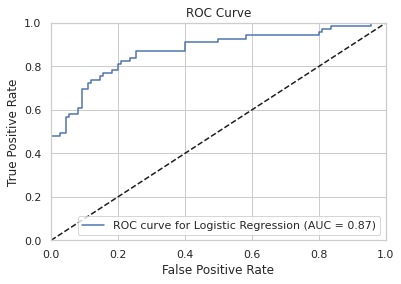

In [128]:
plt_roc_curve("Logistic Regression",log_reg,has_proba=True)

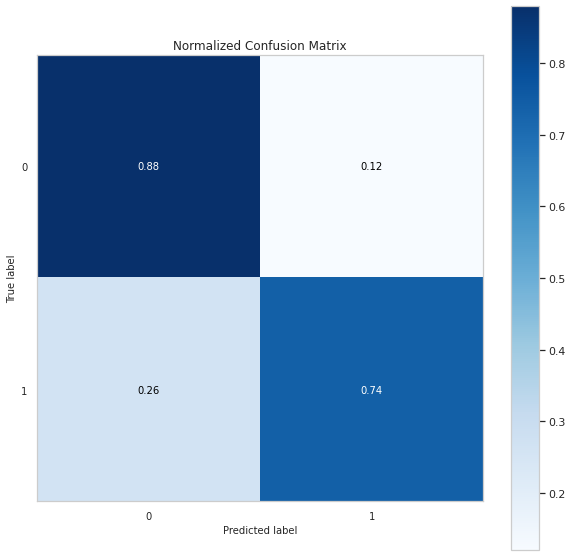

In [129]:
skplt.metrics.plot_confusion_matrix(y_test, log_reg.predict(x_test),normalize=True, figsize=(10,10))

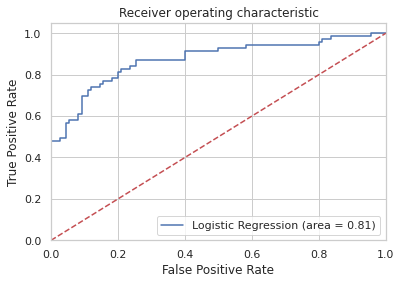

In [130]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [144]:
logit_roc_auc

0.8104743083003952

In [146]:
SVC_rbf=SVC(kernel="rbf", probability=True)
SVC_rbf.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(SVC_rbf)))
confusion_matrix_model(SVC_rbf)

Accuracy: 0.6558652614990643


,Predicted Dead,Predicted Survived
Actual Dead,0.95,0.05
Actual Survived,0.62,0.38


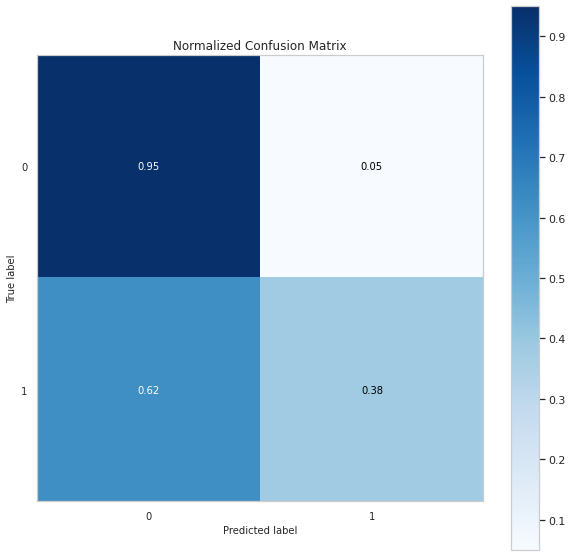

In [147]:
skplt.metrics.plot_confusion_matrix(y_test, SVC_rbf.predict(x_test),normalize=True, figsize=(10,10))

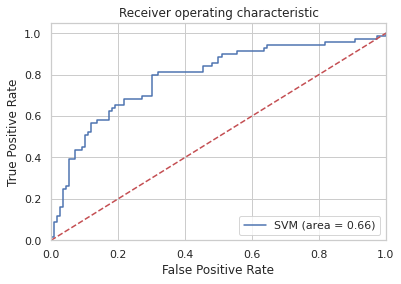

In [148]:
svm_roc_auc = roc_auc_score(y_test, SVC_rbf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, SVC_rbf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [149]:
svm_roc_auc

0.661133069828722

In [133]:
Survived = log_reg.predict(test_df_predict)
Survived = pd.DataFrame({'Survived':Survived})

In [134]:
logreg_submission=pd.concat([test_df_submit, Survived], axis=1)

In [135]:
logreg_submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [136]:
from google.colab import files
logreg_submission.to_csv('logreg_submission.csv', index=False) 

In [137]:
Survived = SVC_rbf.predict(test_df_predict)
Survived = pd.DataFrame({'Survived':Survived})
svm_submission=pd.concat([test_df_submit, Survived], axis=1)
svm_submission.to_csv('svm_submission.csv', index=False) 

In [138]:
gnb = GaussianNB()
gnb.fit(x_train,y_train)

print("Accuracy: " + str(acc_score(gnb)))
confusion_matrix_model(gnb)

Accuracy: 0.7331133655077318


,Predicted Dead,Predicted Survived
Actual Dead,0.83,0.17
Actual Survived,0.23,0.77


In [168]:
gnb.theta_

array([[2.52391800e+00, 8.56492027e-01, 2.96218679e+01, 2.27892920e+01,
        1.82232346e-02, 2.27790433e-02, 4.55580866e-02, 1.82232346e-02,
        1.59453303e-02, 6.83371298e-03, 2.27790433e-03, 2.27790433e-03,
        7.76765376e-01, 1.38952164e-01, 1.91116173e+00],
       [1.98534799e+00, 3.26007326e-01, 2.74926740e+01, 4.64539234e+01,
        2.56410256e-02, 9.52380952e-02, 8.79120879e-02, 6.59340659e-02,
        8.05860806e-02, 2.19780220e-02, 7.32600733e-03, 0.00000000e+00,
        6.52014652e-01, 2.49084249e-01, 1.93772894e+00]])

In [169]:
gnb.classes_

array([0, 1])

In [170]:
print(x_train.columns)

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Cabin A', 'Cabin B', 'Cabin C',
       'Cabin D', 'Cabin E', 'Cabin F', 'Cabin G', 'Cabin T', 'Embarked S',
       'Embarked C', 'FamilySize'],
      dtype='object')


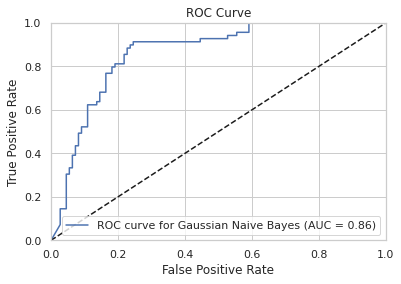

In [139]:
plt_roc_curve("Gaussian Naive Bayes",gnb,has_proba=True)

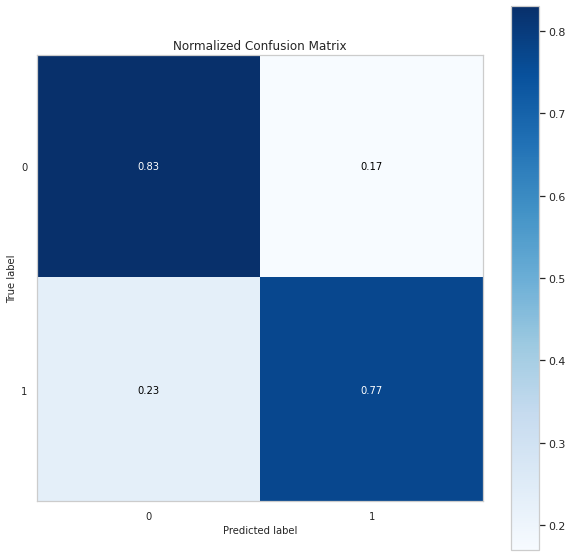

In [140]:
skplt.metrics.plot_confusion_matrix(y_test, gnb.predict(x_test),normalize=True, figsize=(10,10))

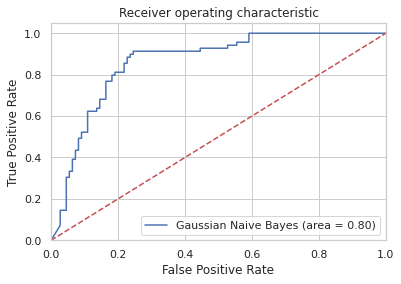

In [141]:
nb_roc_auc = roc_auc_score(y_test, gnb.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gaussian Naive Bayes (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

In [143]:
nb_roc_auc

0.7976943346508564

In [142]:
Survived = gnb.predict(test_df_predict)
Survived = pd.DataFrame({'Survived':Survived})
gnb_submission=pd.concat([test_df_submit, Survived], axis=1)
gnb_submission.to_csv('gnb_submission.csv', index=False) 